In [1]:
from __future__ import division, print_function
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.io.ascii as at
import astropy.io.fits as fits
import astropy.table as table
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.ticker
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.font_manager import FontProperties
import palettable

import K2fov.projection as proj
import K2fov.fov as fov
from K2fov.K2onSilicon import angSepVincenty,getRaDecRollFromFieldnum

from hypra.utils import cat_match, cat_io, k2utils
# from hypra.plot import color_mag
import convertmass

In [94]:
pdat,pobs,pobsnr,pobsr = cat_io.get_data("P")

In [2]:
hdat,hobs,hobsnr,hobsr = cat_io.get_data("H")
print(hdat.dtype)
hpos = SkyCoord(hdat["RA"],hdat["DEC"],unit=u.degree)

(numpy.record, [('RA', '>f8'), ('DEC', '>f8'), ('ASAS_ID', 'S13'), ('HIP_ID', 'S9'), ('KUNDERT_MATCH', '>f4'), ('KUNDERT_RA', '>f4'), ('KUNDERT_DEC', '>f4'), ('KUNDERT_PROT', '>f4'), ('KUNDERT_OBS', '>f4'), ('KUNDERT_SPT', 'S5'), ('ROESER_MATCH', '>i4'), ('ROESER_PMRA', '>f4'), ('ROESER_PMRA_ERR', '>f4'), ('ROESER_PMDEC', '>f4'), ('ROESER_PMDEC_ERR', '>f4'), ('ROESER_PARALLAX', '>f4'), ('ROESER_PARALLAX_ERR', '>f4'), ('ROESER_DISTANCE', '>f4'), ('ROESER_RV', '>f4'), ('ROESER_VPAR', '>f4'), ('ROESER_VPAR_ERR', '>f4'), ('ROESER_VPER', '>f4'), ('ROESER_VPER_ERR', '>f4'), ('ROESER_MASS', '>f4'), ('TWOMASSNAME', 'S16'), ('TWOMASS_RA', '>f8'), ('TWOMASS_DEC', '>f8'), ('TWOMASS_J', '>f4'), ('TWOMASS_JERR', '>f4'), ('TWOMASS_H', '>f4'), ('TWOMASS_HERR', '>f4'), ('TWOMASS_K', '>f4'), ('TWOMASS_KERR', '>f4'), ('TWOMASS_FLAG', 'S3'), ('TWOMASS_PHOT_FLAG', 'S5'), ('TWOMASS_SEP_OPT', '>f4'), ('TWOMASS_B', '>f4'), ('TWOMASS_VR', '>f4'), ('DELORME_MATCH', '>i4'), ('SWASP_ID', 'S25'), ('USNO_ID', 'S12

In [3]:
# Match EPIC IDs
epic_list = at.read("mast_search_13064.csv",data_start=2)
print(epic_list.dtype)
mpos = SkyCoord(epic_list["RA (J2000)"], epic_list["Dec (J2000)"],
               unit=(u.hourangle,u.degree))

[('K2 ID', '<i8'), ('Dataset Name', '<U17'), ('Campaign', '<i8'), ('Object type', '<U14'), ('RA (J2000)', '<U12'), ('Dec (J2000)', '<U12'), ('Target Type', '<U2'), ('Ref', '<i8'), ('Actual Start Time', '<U19'), ('Actual End Time', '<U19'), ('Investigation ID', '<U103'), ('R Mag', '<f8'), ('R Mag Err', '<f8'), ('J Mag', '<f8'), ('J Mag Err', '<f8'), ('KEP Mag', '<f8'), ('Kep Flag', '<U3'), ('Hip ID', '<i8'), ('Tyc ID', '<U11'), ('SDSS ID', '<U20'), ('UCAC ID', '<U10'), ('2MASS ID', '<U16'), ('2MASS Flag', '<U19'), ('Module', '<i8'), ('Output', '<i8'), ('Channel', '<i8'), ('High-Level Science Products', '<i8')]


In [4]:
idx, sep, _ = hpos.match_to_catalog_sky(mpos)
print(len(idx),len(hpos),len(mpos))

good_match = np.where(sep<(5*u.arcsec))[0]
good_idx = idx[good_match]
print(len(good_match),len(good_idx),len(np.unique(good_idx)))

# old_match = np.where((sep<(5*u.arcsec)) & (hdat["EPIC_ID"]>0))[0]
# old_idx = idx[old_match]
# print(hdat["EPIC_ID"][old_match])
# print(epic_list["K2 ID"][old_idx])

# print(hdat["EPIC_ID"][good_match])
# print(epic_list["K2 ID"][good_idx])

hdat["EPIC_ID"][good_match] = epic_list["K2 ID"][good_idx]

786 786 132
132 132 132


In [5]:
print(hdat["EPIC_ID"][hdat["K2FOV_FLAG13"]==2])

[    -9999     -9999     -9999     -9999     -9999     -9999     -9999
     -9999     -9999     -9999     -9999     -9999     -9999     -9999
     -9999     -9999     -9999     -9999     -9999     -9999     -9999
     -9999     -9999     -9999     -9999     -9999     -9999     -9999
     -9999     -9999     -9999     -9999     -9999     -9999     -9999
     -9999     -9999     -9999     -9999     -9999     -9999     -9999
     -9999     -9999 210899260     -9999 210666330     -9999 210675409
 247363759     -9999 246794704 246875518 247857331 210652965 247002634
     -9999 247134293 210551925 248045685 247611242 247369717 246865157
 210554781 246777832 246931087 246732310 210651981 246806983 246862801
 210741091 246714118 210923016 210899231 210828490 210846111 210878579
 210718930 210949810 210945848 210754620 210742017 210667985 210743724
 210640966 210674207 210889984 247755982     -9999 210772187 210552148
 210709514 210726910 247799152 210566619 210558541 210721261 210491860
 24758

In [6]:
htab = Table(hdat)
tab_out = htab["GOLDMAN_SEQ","HIP_ID","TWOMASSNAME","EPIC_ID","RA","DEC",
             "BINARY"][(htab["K2FOV_FLAG13"]==2) & (htab["EPIC_ID"]>0)]

at.write(tab_out,"c13_check_binaries.csv",delimiter=",",overwrite=True)

at.write(tab_out["RA","DEC"],"c13_check_binaries_simbad.csv",overwrite=True)

In [7]:
# ORIGINAL SAMPLE
period_file_base = "c13_tables/c13_k2sc_output_2018-05-29_"

for i in range(4):
    #print(i+1)
    period_file = "{0}{1}.csv".format(period_file_base,i+1)
    new_res = at.read(period_file)
    
    peak_file = "{0}{1}_allpeaks.csv".format(period_file_base,i+1)
    new_peaks = at.read(peak_file)
    if i==0:
        res1 = new_res
        peaks1 = new_peaks
    else:
        res1 = table.vstack([res1,new_res])
        peaks1 = table.vstack([peaks1,new_peaks])
                
res = res1 #table.vstack([res1,res2])
peaks = peaks1 #table.vstack([peaks1,peaks2])
        
        
print(len(res))
print(len(peaks),len(np.unique(peaks["EPIC"])))
print(peaks.dtype)

132
337 129
[('EPIC', '<i8'), ('period', '<f8'), ('power', '<f8'), ('threshold', '<f8')]


In [8]:
# Ensure that this is still sorted by EPIC!
comments = at.read("c13_tables/c13_k2sc_output_2018-05-29_comments_final.csv",delimiter=",")
print(comments.dtype)
print(len(comments))

[('EPIC', '<i8'), ('fund_period', '<f8'), ('fund_power', '<f8'), ('sig_period', '<f8'), ('sig_power', '<f8'), ('sec_period', '<f8'), ('sec_power', '<f8'), ('num_sig', '<i8'), ('harm_type', '<U10'), ('threshold', '<f8'), ('SpotEvol', '<U1'), ('MultiProt', '<U1'), ('Q', '<i8'), ('Q2', '<U1'), ('Q3', '<U1'), ('Notes', '<U144')]
132


In [9]:
print(np.where(comments["Q"]==-1)[0])

[]


In [10]:
res.sort("EPIC")
comments.sort("EPIC")
epic_diff = res["EPIC"] - comments["EPIC"]
print(np.where(epic_diff<0)[0])

[]


In [11]:
print(res.dtype)
k2_periods = res["sig_period"]
k2_power = res["sig_power"]
k2_epic = res["EPIC"]
k2_flag = res["num_sig"]
#k2_kpmag = res["magnitude"]
k2_harm = res["harm_type"]
k2_threshold = res["threshold"]
k2_quality = comments["Q"]
k2_spot = comments["SpotEvol"]
k2_multi = comments["MultiProt"]
k2_comment = comments["Notes"]
# k2_blend = comments["Blended"]

[('EPIC', '<i8'), ('fund_period', '<f8'), ('fund_power', '<f8'), ('sig_period', '<f8'), ('sig_power', '<f8'), ('sec_period', '<f8'), ('sec_power', '<f8'), ('num_sig', '<i8'), ('harm_type', '<U10'), ('threshold', '<f8')]


In [12]:
print(peaks.dtype)

[('EPIC', '<i8'), ('period', '<f8'), ('power', '<f8'), ('threshold', '<f8')]


In [13]:
pperiods = np.copy(hdat['PERIOD'])
pperiods_secondary = np.zeros(len(hdat))
powers_secondary = np.zeros(len(hdat))
quality_secondary = np.zeros(len(hdat),int)
pflag = np.copy(hdat['PERIOD_FLAG'])
pmass = hdat['KH_MASS']
pqual = np.zeros(len(hdat),int)
pbad = np.zeros(len(hdat),int)
ppower = np.zeros(len(hdat))
pthreshold = np.zeros(len(hdat))
pharm = np.empty(len(hdat),"S12")
pharm[:] = ""
# pblend = np.zeros(len(hdat),int)

bad_count = 0
replace_count = 0

In [14]:
potential_new = np.where((hdat["EPIC_ID"]>0) & 
                         (hdat["KH_MASS"]<1.5) & (hdat["KH_MASS"]>0)
                           )[0]

pperiods_allk2 = np.copy(pperiods)
pperiods_onlyk2 = np.ones_like(pperiods)*-9999.0

# peak separation threshold to be considered a binary
min_dpp = 0.2


# Match targets from our catalog to the EPIC results
for i in potential_new:
    
    cat_epic = hdat["EPIC_ID"][i]
    k2_loc = np.where(k2_epic==cat_epic)[0]
    if len(k2_loc)>=1:
#         print(i, k2_loc, k2_epic[k2_loc], hdat["EPIC_ID"][i])
        
        k2_loc = k2_loc[0]
        if ((k2_quality[k2_loc]==2) and (k2_periods[k2_loc]<0)) | (k2_quality[k2_loc]==3):
            # Indicates that no period was detected by the lomb-scargle periodogram
            bad_count += 1
            pqual[i] = 3
            continue
    
        # By default, use the highest significant peak in the light curve
        use_period = k2_periods[k2_loc]
        use_power = k2_power[k2_loc]
        pqual[i] = comments["Q"][k2_loc]
#         print(c5_loc, c5_comment[c5_loc])

        # If I've flagged that peak as bad, then check my flag for the second highest peak
        # If the second period is good or OK, use that one
        if comments["Q"][k2_loc]==2:
            if comments["Q2"][k2_loc] in ["0","1"]:
                use_period = res["sec_period"][k2_loc]
                use_power = res["sec_power"][k2_loc]
                pqual[i] = comments["Q2"][k2_loc]
                replace_count += 1

        # If the first peak is good or OK, then check to see if the second or third peak 
        #  is really a second period
        # AND (new criterion) the peaks must be separated by a certain fraction of the dominant peak
        else:            
            if comments["Q2"][k2_loc] in ["0","1"]:
                
                delta_pp = abs(res["sec_period"][k2_loc] - use_period)/use_period
                
                if delta_pp > min_dpp:
                    pperiods_secondary[i] = res["sec_period"][k2_loc]
                    powers_secondary[i] = res["sec_power"][k2_loc]
                    quality_secondary[i] = comments["Q2"][k2_loc]
                
            # I only saved the first and second periods/powers in my main table,
            # so have to dig into the table of all significant peaks to pull out
            # the third period/power
            elif comments["Q3"][k2_loc] in ["0","1"]:
                epic_peaks = np.where(cat_epic==peaks["EPIC"])[0]
                sorted_heights = np.argsort(peaks["power"][epic_peaks])
                sorted_periods = peaks["period"][epic_peaks][sorted_heights]
                sorted_powers = peaks["power"][epic_peaks][sorted_heights]

                delta_pp = abs(sorted_periods[2] - use_period)/use_period
                
                if delta_pp > min_dpp:
                    pperiods_secondary[i] = sorted_periods[2]
                    powers_secondary[i] = sorted_powers[2]
                    quality_secondary[i] = comments["Q3"][k2_loc]
        
        # Check whether there's already a literature period in my catalog
        # If not, K2 is the dominant period
        if (pflag[i]=="-"):
            pperiods[i] = use_period
            pflag[i] = "3"
            
        # Save the periods to the appropriate arrays and set various flags
        pperiods_allk2[i] = use_period
        pperiods_onlyk2[i] = use_period
        ppower[i] = use_power
        pthreshold[i] = k2_threshold[k2_loc]
#         pbad[i] = c5_flag[c5_loc]
        
#         # If there is definitely a second period or blended neighbor,
#         # flag as a candidate binary
#         if ((k2_multi[k2_loc]=="y") or (k2_multi[k2_loc]=="Y") 
# #            or (k2_blend[k2_loc]=="Y") or (k2_blend[c5_loc]=="y")
#            ):
#             pblend[i] = 1
        
        # Reset quality flag based on number of peaks in the light curve
        epic_peaks = np.where(cat_epic==peaks["EPIC"])[0]
        if len(epic_peaks)>0:
            epic_heights = peaks["power"][epic_peaks]
            pbad[i] = len(np.where(epic_heights>(res["fund_power"][k2_loc]*0.6))[0])
            if pbad[i]>0:
                pbad[i] -= 1
#             print(c5_flag[c5_loc],pbad[i])

        #print(c5_harm[c5_loc],pharm[i])
        pharm[i] = k2_harm[k2_loc][0]
        
print(len(np.where(pperiods_secondary>0)[0]),"with secondary periods")
# print(len(np.where(pblend>0)[0]),"blend/multi")
pblend = np.zeros(len(hdat),int)

11 with secondary periods


In [15]:
c13 = potential_new#np.where((pdat["K2_TARGET"]>0))[0]
print(len(c13),"C13 targets")
print(len(np.where((pperiods_onlyk2>0) & (pqual<2) & (pqual>=0))[0]),"K2 stars with periods")

187 C13 targets
116 K2 stars with periods


In [16]:
# Counting - directly adapted from C5, possibly not the right numbers
# New Periods
new_k2 = np.where((pperiods_onlyk2>0) & (hdat["PERIOD"]<0) & (pqual<2) & (pqual>=0))[0]
print(len(new_k2), " new K2 periods")
quality_k2 = np.where((pperiods_onlyk2>0) & (hdat["PERIOD"]<0) & (pqual==0) & (pbad==0))[0]
print(len(quality_k2), " high quality new K2 periods")
low_quality_k2 = np.where((pperiods_onlyk2>0) & (hdat["PERIOD"]<0) & (pqual==1))[0]
print(len(low_quality_k2), " low quality new K2 periods as flagged by me")
low_quality_k2 = np.where((pperiods_onlyk2>0) & (hdat["PERIOD"]<0) & (pqual==0) & (pbad>0))[0]
print(len(low_quality_k2), " low quality new K2 periods from not-clean periodograms (but I flagged them good)")
low_quality_k2 = np.where((pperiods_onlyk2>0) & (hdat["PERIOD"]<0) & (pqual==1) & (pbad>0))[0]
print(len(low_quality_k2), " low quality new K2 periods as flagged by me AND the periodograms\n")

# Non-detections
print(bad_count," with no K2 detection",bad_count*100/len(c13),"%")
print(len(np.where(pqual==3)[0]),"alternate count of no detections\n")

# Ones I flagged as bad
bad_flag_count = len(np.where((pqual==2))[0])
print("I removed",bad_flag_count,bad_flag_count*100/len(c13),"% leaving",len(c13)-bad_count-bad_flag_count)

# Totals
print("Originally",len(c13),"remove", bad_count, "and", bad_flag_count, "leave", len(c13)-bad_count-bad_flag_count,"\n")

print(np.intersect1d(c13,np.where((pperiods_onlyk2<0) & ((pqual==1) | pqual==0))[0]))
print(np.intersect1d(c13,np.where((pperiods_allk2<0) & ((pqual==1) | pqual==0))[0]))

93  new K2 periods
75  high quality new K2 periods
10  low quality new K2 periods as flagged by me
8  low quality new K2 periods from not-clean periodograms (but I flagged them good)
1  low quality new K2 periods as flagged by me AND the periodograms

3  with no K2 detection 1.6042780748663101 %
3 alternate count of no detections

I removed 13 6.951871657754011 % leaving 171
Originally 187 remove 3 and 13 leave 171 

[ 96 120 132 133 134 150 154 155 156 174 175 184 203 205 268 278 282 284
 286 287 294 295 300 302 304 305 307 309 310 311 312 319 320 321 327 328
 331 344 347 348 353 364 370 371 372 373 376 379 387 393 400 732 737 760
 774]
[174 278 284 302 310 321 328 353 371 400 760]


# A few definitions

In [17]:
poster_figure = (12,7)
talk_figure = (10,6.5)
single_figure = (8,8)
double_figure = (13,6)
double_stacked = (6,13)
triple_stacked = (6,14)
quad_square = (13,10)
proposal_figure = (10,5.5)

std_ms = 8
std_mew = 1.25

In [18]:
# cmap = plt.cm.viridis
# old_color = plt.cm.Greys(0.5)
# k2_color = "Crimson"

cmap = colors.ListedColormap(palettable.colorbrewer.qualitative.Dark2_6.mpl_colors)
cmap_qual = palettable.colorbrewer.qualitative.Dark2_7.mpl_colors
old_color = plt.cm.Greys(0.4)
k2_color = cmap_qual[1]
# matt_color = cmap_qual[3]
# brown_color = cmap_qual[2]
# print(brown_color)

## Period-mass plot

In [19]:
from hypra.plot import period_mass

In [20]:
def calc_mass_unc(mK,mK_err,dist,dist_err):
    # dmod = m-M = 5*log10(d) - 5
    # M = m-dmod = m - 5*log10(d) + 5
    # dM/dd = -5/(d*ln(10))
    dmod = 5.0*np.log10(dist) - 5
    MK = mK - dmod
    
    bad = np.where(mK<-99)[0]
    MK[bad] = -9999

    if type(mK_err)==np.ndarray:
        mK_err_sq = mK_err**2 
    else:
        # actually a fraction, but real errors
        mK_err_sq = (mK_err*mK)**2

    dist_err_sq = (dist_err * 5.0 / (dist * np.log(10.0)))**2

    sigma_MK = np.sqrt(mK_err_sq + dist_err_sq)
    #print(sigma_MK)

    MK_low =  MK + sigma_MK #dimmer/lower mass
    MK_high = MK - sigma_MK #brighter/higher mass
    #print('low',MK_low)
    #print('high',MK_high)
    
    good = np.where((MK>0) & (MK_low>0) & (MK_high>0))[0]

    mass, mass_low, mass_high = np.ones(len(MK))*-9999.,np.ones(len(MK))*-9999.,np.ones(len(MK))*-9999.
    
    mass[good] = convertmass.kraus(MK[good],'K','None')
    mass_low[good] = convertmass.kraus(MK_low[good],'K','None')
    mass_high[good] = convertmass.kraus(MK_high[good],'K','None')

    mass_errs = np.zeros(2*len(mK)).reshape((2,-1))
    
    mass_errs[1][good] = abs(mass_low-mass)[good]
    mass_errs[0][good] = abs(mass_high-mass)[good]

    return mass,mass_errs

0.025564968390695924


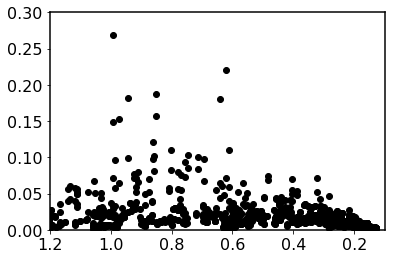

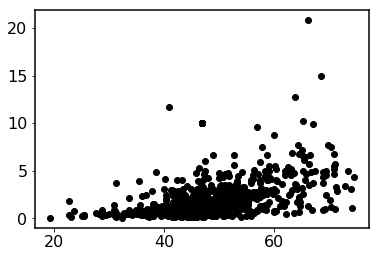

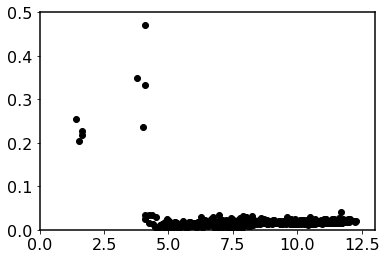

In [21]:
def hyades_mass_unc():
    #mK,mK_err,dist,dist_err
    
    mK = np.copy(hdat["TWOMASS_K"])
    e_mK = np.copy(hdat["TWOMASS_KERR"])

    dist = hdat["DISTANCE"] #pc
    e_dist = hdat["DISTANCE_ERR"] #pc
    
    mass,mass_errs = calc_mass_unc(mK, e_mK, dist, e_dist)
    
    good_mass = np.where(mass>0)[0]
    good_errs = np.zeros(2*len(good_mass)).reshape((2,-1))
    good_errs[0] = mass_errs[0][good_mass]
    good_errs[1] = mass_errs[1][good_mass]

    
    plt.plot(mass[good_mass], good_errs[0],'ko')
    plt.plot(mass[good_mass], good_errs[1],'ko')
    plt.xlim(1.2,0.1)
    plt.ylim(0,0.3)
    
    plt.figure()
    plt.plot(dist,e_dist,'ko')
    plt.figure()
    plt.plot(mK,e_mK,'ko')
    plt.xlim(0,13)
    plt.ylim(0,0.5)
    
    return mass, mass_errs

mass, mass_errs = hyades_mass_unc()
good_mass = np.where(mass>0)[0]
mass_errs2 = (mass_errs[0]+mass_errs[1])/2.0
print(np.median(mass_errs2[good_mass]/mass[good_mass]))

In [22]:
print(np.unique(pflag))

['-' '2' '3' 'D' 'H' 'K' 'P' 'R']


In [23]:
# Read in Kraus & Hillenbrand for later use
kh = at.read(os.path.expanduser('~/HyPra/models/kraushillenbrand5.dat'))
ksub = np.array([-20,-19,-15,-12,-11,-9,-7,-6])#,-5,-4,-3,-2,-1])
ksub = np.arange(-22,-5,2)
kh_mass = kh["Mass"][ksub]
kh_spt = kh['SpT'][ksub]

def add_spt_pm(ax):
    ymax = ax.get_ylim()[1]
    for khm,khs in zip(kh_mass,kh_spt):
        ax.text(khm,ymax*1.01,khs,verticalalignment="bottom",horizontalalignment="center",
               fontsize="x-large")
    ax.xaxis.set_ticks_position('bottom')

In [24]:
def plot_period_vs_x(xx=hdat["KH_MASS"], xerrs=mass_errs,ax=None, plot_binaries=True, mark_binaries=True, sources=True, 
                     logmass=False, mass_unc=False, color_sources="papers",
                     which_sources=['H', 'P', 'R', 'D', 'K', '2', '3'],qual=0,min_pmem=70,max_bad=0,
                     textx=1.25,print_sources=True):
    
    good_quality = (pqual>=0) & (pqual<=qual) & (pbad<=max_bad)
    
    #color1 = plt.cm.inferno(0.5)
    #color2 = plt.cm.inferno(0.75)
    
    #cmap = plt.cm.viridis
    
    old_color = "k"
    max_bad = 0

    if color_sources=="papers":
        # TODO: FIX THESE TO MATCH OTHER PLOTS
        pcolors = {"D": cmap_qual[2],
                   "K": cmap_qual[4],
                   "R": cmap_qual[5],
                   "P": cmap_qual[0],
                   "H": cmap_qual[6],
                   "2": cmap_qual[3],
                   "3": k2_color
                  }

    elif color_sources=="old":
#         pcolors = {"D": 'DarkGrey', "K": 'DarkGrey', "S": 'DarkGrey',
#                    "2": "Red", "P": 'DarkGrey', "H": 'DarkGrey'}
        old_color = plt.cm.Greys(0.4)#"#cccccc" #"DarkGrey"
        pcolors = {"H": old_color,
                   "P": old_color,
                   "R": old_color,
                   "D": old_color,
                   "K": old_color,
                   "2": old_color,
                   "3": k2_color
                  }
    elif color_sources=="background":
        old_color = plt.cm.Greys(0.4)#"#cccccc" #"DarkGrey"
        pcolors = {"H": old_color,
                   "P": old_color,
                   "R": old_color,
                   "D": old_color,
                   "K": old_color,
                   "2": old_color,
                   "3": old_color,
                  }
    plabels = {"D": 'Delorme+ 2011', "K": 'ASAS (D14)', "R": 'Radick+ 1987,1995',
               "2": "K2 C4 (D16)", "P": 'Prosser+ 1995', "H": 'Hartman+2011',
              "3": "K2 C13 (This Work)"}
    
    if "3" in which_sources:
        plotbink2 = True
    else:
        plotbink2 = False
        
    ms_off = 1.5

    
    if ax is None:
        fig = plt.figure(figsize=single_figure)
        ax = plt.subplot(111)
        

    ax.plot([],[],'D', ms=std_ms-ms_off, mew=std_mew,mec='k',mfc='k',label=r"Hyades")# (P$_{mem}$>%.0f%%, Quality<=%i)" % (min_pmem, qual))
    if plot_binaries==True:
        # Binaries included
        
        if (sources==False) & (mass_unc==True):
            bin_loc = np.where(good_quality & ((hdat["BINARY"]>=1) | (pblend>0)))[0]
            sub_errs = np.zeros(2*len(bin_loc)).reshape((2,-1))
            sub_errs[0] = xerrs[0][bin_loc]
            sub_errs[1] = xerrs[1][bin_loc]
            ax.errorbar(xx[bin_loc],pperiods[bin_loc],xerr=sub_errs,linestyle="None",
                        color="k",ecolor="k",zorder=-111,elinewidth=1.5,mew=1.5)
        elif (sources==True) & (mass_unc==True):
            for k in which_sources:
                bin_loc = np.where(good_quality & ((hdat["BINARY"]>=1) | (pblend>0)) & (pflag==k))[0]
                sub_errs = np.zeros(2*len(bin_loc)).reshape((2,-1))
                sub_errs[0] = xerrs[0][bin_loc]
                sub_errs[1] = xerrs[1][bin_loc]
                ax.errorbar(xx[bin_loc],pperiods[bin_loc],xerr=sub_errs,linestyle="None",
                            color=pcolors[k],ecolor=pcolors[k],zorder=-111,elinewidth=1.5,mew=1.5)
    
            
        if (sources==True) & (mark_binaries==True):
            for k in which_sources:
                ax.plot(xx[(pflag==k) & (hdat["BINARY"]==1) & good_quality],
                        pperiods[(pflag==k) & (hdat["BINARY"]==1) & good_quality],
                        'D',mec=pcolors[k],mfc='None', ms=std_ms-ms_off, mew=std_mew)

                ax.plot(xx[(pflag==k) & (hdat["BINARY"]>=2) & good_quality],
                        pperiods[(pflag==k) & (hdat["BINARY"]>=2) & good_quality],
                        '+',mec=pcolors[k],mfc='None', ms=std_ms, mew=std_mew)
                
                ax.plot(xx[(pflag==k) & (hdat["BINARY"]==0) & good_quality & (pblend==1)],
                        pperiods[(pflag==k) & (hdat["BINARY"]==0) & good_quality & (pblend==1)],
                        's',mec=pcolors[k],mfc='None',ms=std_ms, mew=std_mew) #'s'
                
        elif (sources==True) & (mark_binaries==False):
            for k in which_sources:
                ax.plot(xx[(pflag==k) & ((hdat["BINARY"]>=1) | (pblend>0)) & good_quality],
                        pperiods[(pflag==k) & ((hdat["BINARY"]>=1) | (pblend>0)) & good_quality],
                        'D',mec=pcolors[k],mfc=pcolors[k], ms=std_ms-ms_off, mew=std_mew)
        else:
            ax.plot(xx[(pperiods>0) & (hdat["BINARY"]==1) & good_quality],
                    pperiods[(pperiods>0) & (hdat["BINARY"]==1) & good_quality],
                    'D',mec='k',mfc='None', ms=std_ms-ms_off, mew=std_mew)
            ax.plot(xx[(pperiods>0) & (hdat["BINARY"]>=2) & good_quality],
                    pperiods[(pperiods>0) & (hdat["BINARY"]>=2) & good_quality],
                    '+',mec='k', ms=std_ms, mew=std_mew)
            ax.plot(xx[(pperiods>0) & (hdat["BINARY"]==0) & good_quality & (pblend==1)],
                    pperiods[(pperiods>0) & (hdat["BINARY"]==0) & good_quality & (pblend==1)],
                    's',mec='k',mfc='None', ms=std_ms, mew=std_mew)#'s'
            
        if mark_binaries==True:
            ax.plot([],[],'D', ms=std_ms-ms_off, mew=std_mew,mec='k',mfc='None',label="Candidate Binary")
            ax.plot([],[],'+', ms=std_ms, mew=std_mew,mec='k',mfc='None',label="Confirmed Binary")
            ax.plot([],[],'s', ms=std_ms, mew=std_mew,mec='k',mfc='None',label="Blend / Multiperiod")

    # Binaries excluded
    if sources==True:
        
        for k in which_sources:
            if mass_unc==True:
                bin_loc = np.where((hdat["BINARY"]==0) & (pflag==k) & good_quality
                                   & (pblend==0))[0]
                sub_errs = np.zeros(2*len(bin_loc)).reshape((2,-1))
                sub_errs[0] = xerrs[0][bin_loc]
                sub_errs[1] = xerrs[1][bin_loc]
                ax.errorbar(xx[bin_loc],pperiods[bin_loc],xerr=sub_errs,linestyle="None",
                            color=pcolors[k],ecolor=pcolors[k],zorder=-111,elinewidth=1.5,mew=1.5)

            ax.plot(xx[(pflag==k) & (hdat["BINARY"]==0) & good_quality & (pblend==0)],
                    pperiods[(pflag==k) & (hdat["BINARY"]==0) & good_quality & (pblend==0)],
                    'D',mec=pcolors[k],mfc=pcolors[k], ms=std_ms-ms_off, mew=std_mew)
            
            if (k=="2") and (plotbink2 is True):
                ax.plot(xx[(pflag==k) & (hdat["BINARY"]==1) & good_quality],
                        pperiods[(pflag==k) & (hdat["BINARY"]==1) & good_quality],
                        'D',mec=pcolors[k],mfc='None', ms=std_ms-ms_off, mew=std_mew)

                ax.plot(xx[(pflag==k) & (hdat["BINARY"]>=2) & good_quality],
                        pperiods[(pflag==k) & (hdat["BINARY"]>=2) & good_quality],
                        '+',mec=pcolors[k],mfc='None', ms=std_ms, mew=std_mew)                

                ax.plot(xx[(pflag==k) & (hdat["BINARY"]==0) & good_quality & (pblend==1)],
                        pperiods[(pflag==k) & (hdat["BINARY"]==0) & good_quality & (pblend==1)],
                        's',mec=pcolors[k],mfc='None', ms=std_ms, mew=std_mew)                #'s'

        if logmass==True:
            texty = np.logspace(np.log10(0.15),np.log10(0.8),num=9)
            textx = 0.94
        else:
            texty = np.logspace(np.log10(0.12),np.log10(0.8),num=9)
            
        ycount = 7
        textsize = 14
        if (color_sources=="papers") and (print_sources is True):
            ax.text(textx,texty[8],'Periods from',color='k',fontsize=textsize)
            for k in which_sources:
                print(textx, texty[ycount])
                ax.text(textx,texty[ycount], plabels[k], color=pcolors[k], fontsize=textsize)
                ycount -= 1
        elif (color_sources=="old") and (("2" in which_sources)==True)  and (print_sources is True):
            ax.text(textx,texty[8],'Periods from',color='k',fontsize=textsize)
            ax.text(textx,texty[7], plabels["3"], color=pcolors["3"], fontsize=textsize)
#            ax.text(textx,texty[4], "Previous Studies", color="DarkGrey", fontsize='xx-large')
            ycount = 6
            for k in ['H', 'P', 'R', 'D', 'K', "2"]:
                print(textx, texty[ycount])
                ax.text(textx,texty[ycount], plabels[k], color=plt.cm.Greys(0.5), 
                        fontsize=textsize)
                ycount -= 1
                
    else:
        single_loc = ((pperiods>0) & (hdat["BINARY"]==0) & good_quality & (pblend==0))
        if mass_unc is True:
            sub_errs = np.zeros(2*len(np.where(single_loc)[0])).reshape((2,-1))
            sub_errs[0] = xerrs[0][single_loc]
            sub_errs[1] = xerrs[1][single_loc]
            ax.errorbar(xx[single_loc],pperiods[single_loc],xerr=sub_errs,linestyle="None",
                        color="k",ecolor="k",zorder=-111,elinewidth=1.5,mew=1.5)
        ax.plot(xx[single_loc],pperiods[single_loc],
                'D',mec='k',mfc='k', ms=std_ms-ms_off, mew=std_mew)

    ax.legend(loc=2,numpoints=1,handletextpad=0.1,borderaxespad=0,frameon=False,fontsize=14)

    return ax

    
def plot_period_mass(ax=None, plot_binaries=True, mark_binaries=True, sources=True, 
                     logmass=False, mass_unc=False, color_sources="papers",
                     which_sources=['H','P','R','D','K','2','3'],qual=0,min_pmem=70,max_bad=0,
                     textx=1.25,print_sources=True):
    
    ax = plot_period_vs_x(xx=hdat["KH_MASS"], xerrs=mass_errs, ax=ax, plot_binaries=plot_binaries,
                          mark_binaries=mark_binaries, sources=sources, 
                         logmass=logmass, mass_unc=mass_unc, color_sources=color_sources,
                         which_sources=which_sources,qual=qual,min_pmem=min_pmem,
                         textx=textx,max_bad=max_bad,print_sources=print_sources)

    ax.set_ylim(0.1,50)
    ax.set_yscale('log')
    ax.set_xlabel(r'Mass ($M_{\odot}$)',fontsize=20)
    ax.set_ylabel('Period (d)',fontsize=20)
    ax.tick_params(labelsize=20,width=2, length=8)
    ax.tick_params(which="minor",width=2, length=4)
    ax.set_yticklabels(["","0.1","1","10"])

    if logmass==True:
        ax.set_xscale("log")
        ax.set_xlim(1,0.1)
        ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(["","0.1","1"]))
        ax.xaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%0.1f"))
        ax.tick_params(which="minor",labelsize=12)

    else:
        ax.set_xlim(1.3,0.1)
        ax.set_xticks(np.arange(0.1,1.4,0.1),minor=True)
    

    ## K2 thruster firing harmonics
    #for harm in np.append(0.25,np.arange(0.5,1.6,0.6)):
    #    ax.axhline(harm,color='LightGrey',ls="--")

1.25 0.49786638183078274
1.25 0.39275724873943846
1.25 0.30983866769659335
1.25 0.2444257879596462
1.25 0.19282282054671643
1.25 0.15211422834700888
1.25 0.49786638183078274
1.25 0.39275724873943846
1.25 0.30983866769659335
1.25 0.2444257879596462
1.25 0.19282282054671643
1.25 0.15211422834700888


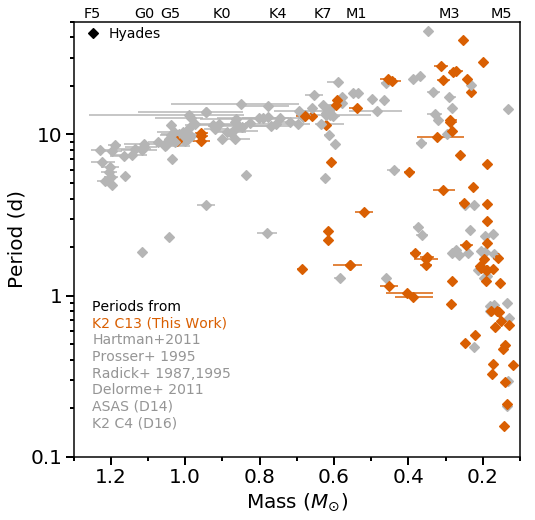

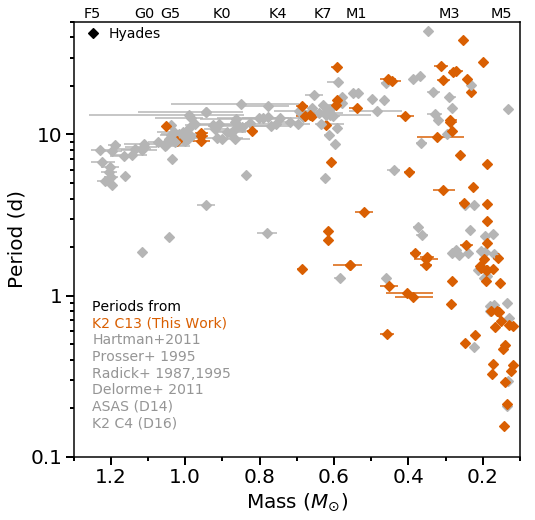

In [41]:
fig = plt.figure(figsize=single_figure)
ax = plt.subplot(111)
plot_period_mass(ax=ax, plot_binaries=True, sources=True, logmass=False,
                 color_sources="old", mark_binaries=False,
                 mass_unc=True, qual=0,min_pmem=70,max_bad=0)
add_spt_pm(ax=ax)

#ax.tick_params(labelsize="xx-large")
#ax.legend_.remove()
#ax.legend(loc=2,numpoints=1,handletextpad=0.1,borderaxespad=0.15,frameon=False,fontsize=14)

plt.savefig("periodmass_hyades_c13_nobinaries.png",bbox_inches="tight",
           dpi=600)

fig = plt.figure(figsize=single_figure)
ax = plt.subplot(111)
plot_period_mass(ax=ax, plot_binaries=True, sources=True, logmass=False,
                 color_sources="old", mark_binaries=False,
                 mass_unc=True, qual=1,min_pmem=70,max_bad=0)
add_spt_pm(ax=ax)

#ax.tick_params(labelsize="xx-large")
#ax.legend_.remove()
#ax.legend(loc=2,numpoints=1,handletextpad=0.1,borderaxespad=0.15,frameon=False,fontsize=14)

plt.savefig("periodmass_hyades_c13_nobinaries_lowqual.png",bbox_inches="tight",
           dpi=600)

1.25 0.6311046707675568
1.25 0.49786638183078274
1.25 0.39275724873943846
1.25 0.30983866769659335
1.25 0.2444257879596462
1.25 0.19282282054671643


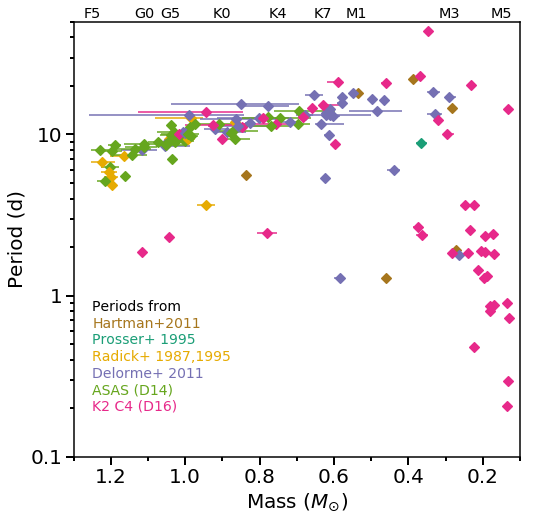

In [26]:
plot_period_mass(ax=None,  plot_binaries=True, mark_binaries=False, 
                sources=True, which_sources=['H','P','R','D','K','2'], 
                 color_sources="papers", mass_unc=True)
ax = plt.gca()
add_spt_pm(ax=ax)
ax.legend_.remove()


plt.savefig(os.path.expanduser("~/my_papers/hyadesk22/periodmass_oldcolor.eps"),
            bbox_inches="tight")

1.25 0.6311046707675568
1.25 0.49786638183078274
1.25 0.39275724873943846
1.25 0.30983866769659335
1.25 0.2444257879596462
1.25 0.19282282054671643
1.25 0.15211422834700888


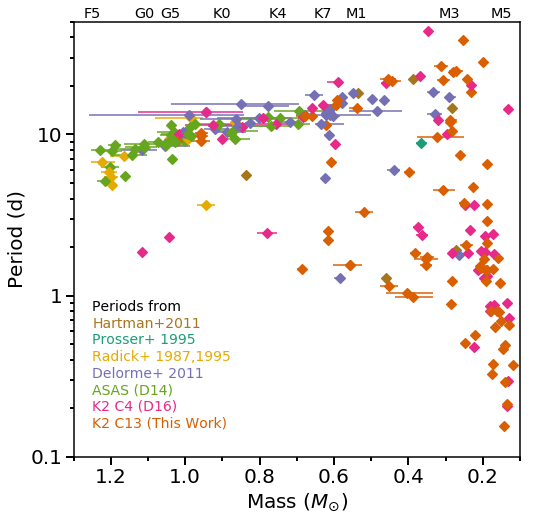

In [27]:
plot_period_mass(ax=None,  plot_binaries=True, mark_binaries=False, 
                sources=True, which_sources=['H','P','R','D','K','2','3'], 
                 color_sources="papers", mass_unc=True)
ax = plt.gca()
add_spt_pm(ax=ax)
ax.legend_.remove()

# # plt.savefig("/home/stephanie/Dropbox/plots_for_sharing/praesepe_periodmass_oldcolor.png", bbox_inches="tight")
# # plt.savefig("../k2_plots/periodmass_oldcolor.png", bbox_inches="tight")
# plt.savefig("/home/stephanie/my_papers/praeK2/periodmass_oldcolor.png", bbox_inches="tight")
# plt.savefig("/home/stephanie/my_papers/praeK2/fig1.eps", bbox_inches="tight")
# plt.savefig("/home/stephanie/my_papers/praeK2/fig1.pdf", bbox_inches="tight")

1.25 0.49786638183078274
1.25 0.39275724873943846
1.25 0.30983866769659335
1.25 0.2444257879596462
1.25 0.19282282054671643
1.25 0.15211422834700888


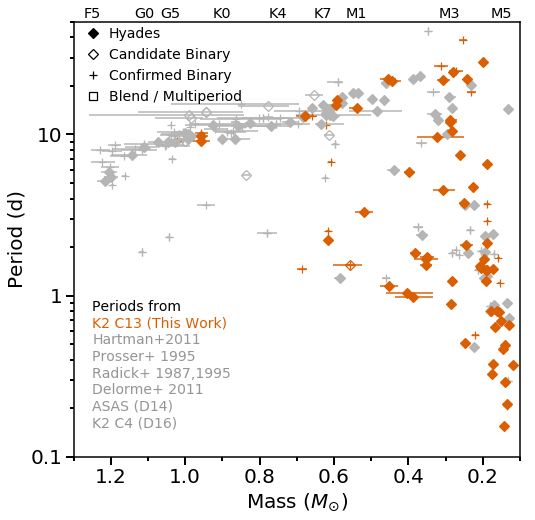

In [28]:
plot_period_mass(ax=None, plot_binaries=True, sources=True, 
                 which_sources=['H','P','R','D','K','2','3'], 
                 color_sources="old", mass_unc=True)
ax = plt.gca()
add_spt_pm(ax=ax)

plt.savefig(os.path.expanduser("~/my_papers/hyadesk22/periodmass_hyades_newk2.eps"),
            bbox_inches="tight")
# plt.savefig("../k2_plots/periodmass_old.png", bbox_inches="tight")

In [ ]:
fig = plt.figure(figsize=single_figure)
ax2 = plt.subplot(111)
plot_period_mass(ax=ax2, plot_binaries=True, sources=False, logmass=False, mass_unc=True,
                 which_sources=['H','P','R','D','K','2','3'],qual=0,min_pmem=70,max_bad=0)
ax2.legend_.remove()

ax2.plot(matt650_mass,matt650_period,"*",mec=model_color,mfc=model_color,label="Matt+2015 - 653 Myr",ms=std_ms,mew=std_mew,zorder=-1)
ax2.legend(loc=3,numpoints=1,handletextpad=0.1,borderaxespad=0,frameon=False,fontsize="x-large")
ax2.set_ylabel("")
ax2.set_xlabel("")
add_spt_pm(ax=ax2)

# Compare to Matt+2015 models

In [29]:
matt650 = at.read(os.path.expanduser("~/HyPra/models/Mattea2015_00653Myr.txt"))
matt650_mass = matt650["col1"][:1000]
matt650_period = matt650["col2"][:1000]
matt575 = at.read(os.path.expanduser("~/HyPra/models/Mattea2015_00574Myr.txt"))
matt575_mass = matt575["col1"][:500]
matt575_period = matt575["col2"][:500]
matt750 = at.read(os.path.expanduser("~/HyPra/models/Mattea2015_00742Myr.txt"))
matt750_mass = matt750["col1"][:500]
matt750_period = matt750["col2"][:500]
matt850 = at.read(os.path.expanduser("~/HyPra/models/Mattea2015_00837Myr.txt"))
matt850_mass = matt850["col1"][:500]
matt850_period = matt850["col2"][:500]
matt1050 = at.read(os.path.expanduser("~/HyPra/models/Mattea2015_01058Myr.txt"))
matt1050_mass = matt1050["col1"][:500]
matt1050_period = matt1050["col2"][:500]

In [30]:
color_idx = np.linspace(0,1,6)

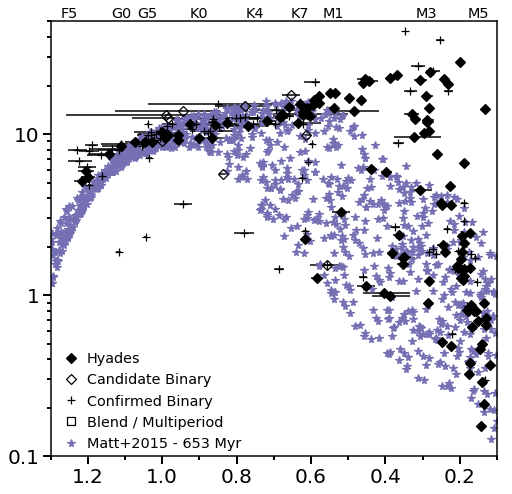

In [31]:
fig = plt.figure(figsize=single_figure)
ax2 = plt.subplot(111)
plot_period_mass(ax=ax2, plot_binaries=True, sources=False, logmass=False, mass_unc=True,
                 which_sources=['H','P','R','D','K','2','3'],qual=0,min_pmem=70,max_bad=0)
ax2.legend_.remove()
model_color = cmap(color_idx[2]) 
ax2.plot(matt650_mass,matt650_period,"*",mec=model_color,mfc=model_color,label="Matt+2015 - 653 Myr",ms=std_ms,mew=std_mew,zorder=-1)
ax2.legend(loc=3,numpoints=1,handletextpad=0.1,borderaxespad=0,frameon=False,fontsize="x-large")
ax2.set_ylabel("")
ax2.set_xlabel("")
add_spt_pm(ax=ax2)

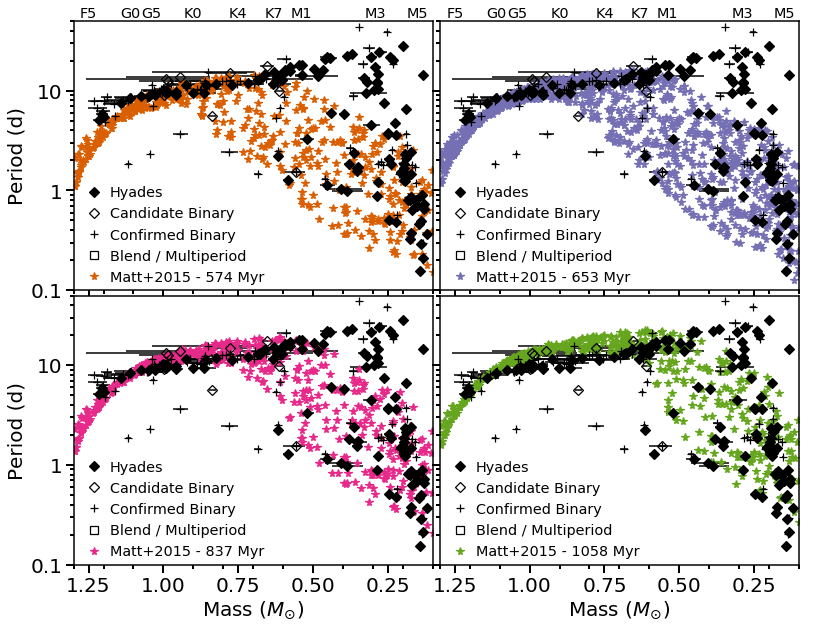

In [32]:
fig = plt.figure(figsize=quad_square)

ax1 = plt.subplot(221)
plot_period_mass(ax=ax1, plot_binaries=True, sources=False, logmass=False, mass_unc=True,
                 which_sources=['H','P','R','D','K','2','3'],qual=0,min_pmem=70,max_bad=0)
ax1.legend_.remove()
model_color = cmap(color_idx[1])
ax1.plot(matt575_mass,matt575_period,"*",mec=model_color,mfc=model_color,label="Matt+2015 - 574 Myr",ms=std_ms,mew=std_mew,zorder=-1)
ax1.legend(loc=3,numpoints=1,handletextpad=0.1,borderaxespad=0,frameon=False,fontsize="x-large")
ax1.set_xlabel("")
add_spt_pm(ax=ax1)
ax1.tick_params(labelbottom=False)

ax2 = plt.subplot(222,sharex=ax1,sharey=ax1)
plot_period_mass(ax=ax2, plot_binaries=True, sources=False, logmass=False, mass_unc=True,
                 which_sources=['H','P','R','D','K','2','3'],qual=0,min_pmem=70,max_bad=0)
ax2.legend_.remove()
model_color = cmap(color_idx[2]) 
ax2.plot(matt650_mass,matt650_period,"*",mec=model_color,mfc=model_color,label="Matt+2015 - 653 Myr",ms=std_ms,mew=std_mew,zorder=-1)
ax2.legend(loc=3,numpoints=1,handletextpad=0.1,borderaxespad=0,frameon=False,fontsize="x-large")
ax2.set_ylabel("")
ax2.set_xlabel("")
add_spt_pm(ax=ax2)
ax2.tick_params(labelbottom=False,labelleft=False)

ax3 = plt.subplot(223,sharex=ax1,sharey=ax1)
plot_period_mass(ax=ax3, plot_binaries=True, sources=False, logmass=False, mass_unc=True,
                 which_sources=['H','P','R','D','K','2','3'],qual=0,min_pmem=70,max_bad=0)
ax3.legend_.remove()
model_color = cmap(color_idx[3]) 
# ax3.plot(matt750_mass,matt750_period,"*",mec=model_color,mfc=model_color,label="Matt+2015 - 742 Myr",ms=std_ms,mew=std_mew,zorder=-1)
ax3.plot(matt850_mass,matt850_period,"*",mec=model_color,mfc=model_color,label="Matt+2015 - 837 Myr",ms=std_ms,mew=std_mew,zorder=-1)
ax3.legend(loc=3,numpoints=1,handletextpad=0.1,borderaxespad=0,frameon=False,fontsize="x-large")

ax4 = plt.subplot(224,sharex=ax1,sharey=ax1)
plot_period_mass(ax=ax4, plot_binaries=True, sources=False, logmass=False, mass_unc=True,
                 which_sources=['H','P','R','D','K','2','3'],qual=0,min_pmem=70,max_bad=0)
ax4.legend_.remove()
model_color = cmap(color_idx[4]) 
# ax4.plot(matt850_mass,matt850_period,"*",mec=model_color,mfc=model_color,label="Matt+2015 - 837 Myr",ms=std_ms,mew=std_mew,zorder=-1)
ax4.plot(matt1050_mass,matt1050_period,"*",mec=model_color,mfc=model_color,label="Matt+2015 - 1058 Myr",ms=std_ms,mew=std_mew,zorder=-1)
ax4.legend(loc=3,numpoints=1,handletextpad=0.1,borderaxespad=0,frameon=False,fontsize="x-large")
ax4.set_ylabel("")
ax4.tick_params(labelleft=False)

plt.subplots_adjust(hspace=0.02,wspace=0.02)
# plt.savefig("/home/stephanie/Dropbox/talks/hypra figs/praesepe_compmatt_k2sc_withbinaries_four.png", bbox_inches="tight", dpi=300)
# plt.savefig("../k2_plots/praesepe_compmatt_k2sc_withbinaries_four.png", bbox_inches="tight", dpi=300)

# Compare to literature periods

0 134
1 4


/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(0.1, 75)

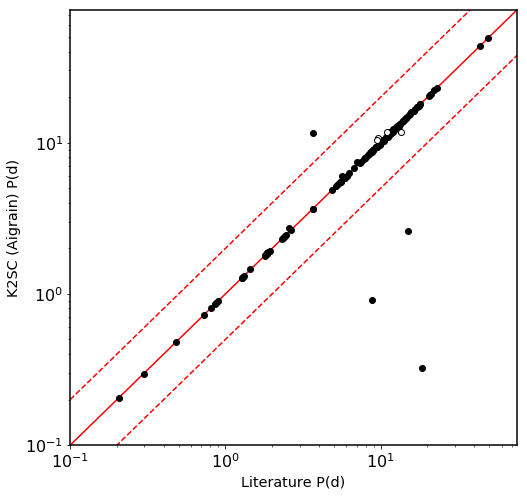

In [33]:
max_qual=2

comparison_set = (pflag!="3") & (pflag!="-") & (pperiods_allk2>0) & (pbad<=1)
plt.figure(figsize=single_figure)
ax = plt.subplot(111)
ax.set_color_cycle([plt.cm.Greys(i) for i in np.linspace(0, 1, max_qual)[::-1]])

x = np.linspace(0.1,99,100)
ax.plot(x,x,'r-') 
ax.plot(x,x*2,'r--')
ax.plot(x,x/2,'r--')
# ax.plot(1/(1/x + 1),x,'r-.')
# ax.plot(1/(1/x - 1),x,'r-.')

for q in np.arange(max_qual):
    qual = (pqual==q) & comparison_set
    print(q,len(np.where(qual)[0]))
    ax.plot(pperiods[qual],pperiods_allk2[qual],'o',mec="k")
ax.set_xlabel("Literature P(d)",fontsize="x-large")
ax.set_ylabel("K2SC (Aigrain) P(d)",fontsize="x-large")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.1,75)
ax.set_ylim(0.1,75)
# plt.savefig("../k2_plots/compare_lit_k2sc.png", bbox_inches="tight")

K2+lit: 23
H With two measurements: 1 Significantly different: 0
P With two measurements: 1 Significantly different: 1
R With two measurements: 2 Significantly different: 1
D With two measurements: 9 Significantly different: 2
K With two measurements: 5 Significantly different: 2
2 With two measurements: 5 Significantly different: 0


/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


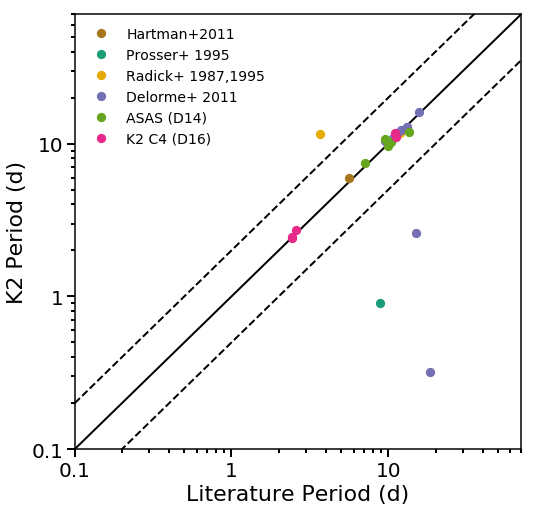

In [82]:
pcolors = {"D": cmap_qual[2],
           "K": cmap_qual[4],
           "R": cmap_qual[5],
           "P": cmap_qual[0],
           "H": cmap_qual[6],
           "2": cmap_qual[3],
           "3": k2_color}
plabels = {"D": 'Delorme+ 2011', "K": 'ASAS (D14)', "R": 'Radick+ 1987,1995',
           "2": "K2 C4 (D16)", "P": 'Prosser+ 1995', "H": 'Hartman+2011',
          "3": "K2 C13 (This Work)"}
    

comparison_set = (hdat["PERIOD"]>0.01) & (pperiods_onlyk2>0.01) & ((pqual==0) | (pqual==1))
print("K2+lit:",len(np.where(comparison_set)[0]))
plt.figure(figsize=single_figure)
ax = plt.subplot(111)

x = np.linspace(0.1,99,100)
ax.plot(x,x,'k-',lw=2) 
ax.plot(x,x*2,'k--',lw=2)
ax.plot(x,x/2,'k--',lw=2)

# ax.plot(1/(1.0/x + 1.0),x,'k-.',lw=2)
# ax.plot(x,1/(1.0/x + 1.0/3.0),'k-.')
# for p in np.arange(2,10):
#     ax.plot(1/(1.0/x + 1./p),x,'k-.')
#     ax.plot(x,1/(1.0/x + 1./p),'k-.') # This math might be wrong?
# ax.plot(1/(1/x + 1/29.5),x,'k-.')

diff_set = np.array([])
diff_k2 = np.array([])
diff_lit = np.array([])
for s in ['H','P','R','D','K','2']:
    qual = (pflag==s) & comparison_set
    diff_k2 = np.append(diff_k2,pperiods_onlyk2[qual])
    diff_lit = np.append(diff_lit,pperiods[qual])
    qepic = hdat["EPIC_ID"][qual]
    # Check for significant discrepancies
    diff = abs(pperiods[qual]-pperiods_allk2[qual])/pperiods_allk2[qual]
    sig_diff = np.where(diff>0.1)[0]
    diff_set = np.append(diff_set, np.where(qual)[0][sig_diff])
    diff_sec = abs(pperiods[qual]-pperiods_secondary[qual])/pperiods_secondary[qual]
    sig_diff_sec = np.where(diff_sec>0.1)[0]
    diff_set = np.append(diff_set, np.where(qual)[0][sig_diff_sec])
    print(s,"With two measurements:",len(np.where(qual)[0]),
          "Significantly different:",len(sig_diff))
#     print(qepic[sig_diff])
#     print(pperiods[qual][sig_diff])
#     print(pperiods_onlyk2[qual][sig_diff])
#     ax.plot(pperiods[qual],pperiods_allc5[qual],'o',mfc="none",mec=pcolors[s],
#             mew=std_mew,ms=std_ms)
#     ax.plot(pperiods[qual & (pblend==0)],pperiods_allc5[qual & (pblend==0)],'o',
#             mfc=pcolors[s],mec=pcolors[s],label=plabels[s],ms=std_ms,mew=std_mew)
    ax.plot(pperiods[qual],pperiods_allk2[qual],'o',mec=pcolors[s],
            mew=std_mew,ms=std_ms,mfc=pcolors[s],label=plabels[s])
ax.set_xlabel("Literature Period (d)",fontsize=22)
ax.set_ylabel("K2 Period (d)",fontsize=22)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.1,70)
ax.set_ylim(0.1,70)
ax.tick_params(labelsize=20,width=2, length=8)
ax.tick_params(which="minor",width=2, length=4)
ax.set_yticklabels(["","0.1","1","10"])
ax.set_xticklabels(["","0.1","1","10"])
ax.legend(loc=2,frameon=False, numpoints=1)
plt.savefig(os.path.expanduser("~/my_papers/hyadesk22/compare_lit_color.eps"),
                               bbox_inches="tight")
# plt.savefig("/home/stephanie/my_papers/praeK2/fig8.eps", bbox_inches="tight")
# plt.savefig("/home/stephanie/my_papers/praeK2/fig8.pdf", bbox_inches="tight")
# plt.savefig("/home/stephanie/my_papers/praeK2/compare_lit_k2sc_litcolor.png", bbox_inches="tight")

H With two measurements: 1 Significantly different: 0
[]
[]
[]
P With two measurements: 1 Significantly different: 1
[210558541]
[8.8]
[0.9041]
R With two measurements: 2 Significantly different: 1
[210554781]
[3.66]
[11.5143]
D With two measurements: 9 Significantly different: 2
[246806983 246714118]
[14.94 18.41]
[2.6103 0.3216]
['1SWASPJ051109.69+154857.5' '1SWASPJ043033.88+144453.1']
K With two measurements: 5 Significantly different: 2
[210666330 247369717]
[ 9.551653 13.589424]
[10.6945 11.8317]
2 With two measurements: 5 Significantly different: 0
[]
[]
[]


/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


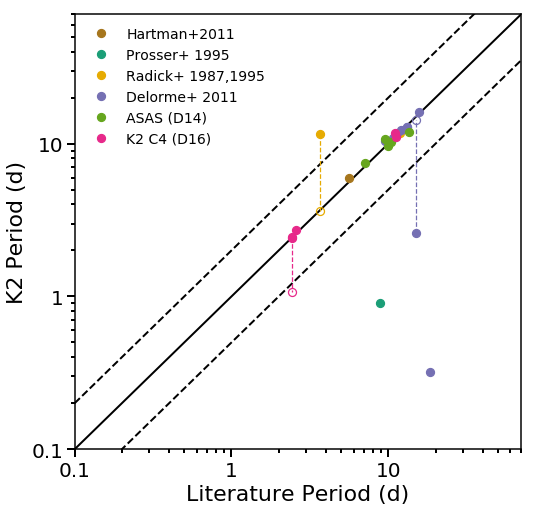

In [83]:

plt.figure(figsize=single_figure)
ax = plt.subplot(111)

x = np.linspace(0.1,99,100)
ax.plot(x,x,'k-',lw=2) 
ax.plot(x,x*2,'k--',lw=2)
ax.plot(x,x/2,'k--',lw=2)

# ax.plot(1/(1.0/x + 1.0),x,'k-.',lw=2)
# ax.plot(x,1/(1.0/x + 1.0/3.0),'k-.')
# for p in np.arange(2,10):
#     ax.plot(1/(1.0/x + 1./p),x,'k-.')
#     ax.plot(x,1/(1.0/x + 1./p),'k-.') # This math might be wrong?
# ax.plot(1/(1/x + 1/29.5),x,'k-.')

diff_set = np.array([])
diff_k2 = np.array([])
diff_lit = np.array([])
for s in ['H','P','R','D','K','2']:
    qual = (pflag==s) & comparison_set
    diff_k2 = np.append(diff_k2,pperiods_onlyk2[qual])
    diff_lit = np.append(diff_lit,pperiods[qual])
    qepic = hdat["EPIC_ID"][qual]
    # Check for significant discrepancies
    diff = abs(pperiods[qual]-pperiods_allk2[qual])/pperiods_allk2[qual]
    sig_diff = np.where(diff>0.1)[0]
    diff_set = np.append(diff_set, np.where(qual)[0][sig_diff])
    # And for secondary periods
    diff_sec = abs(pperiods[qual]-pperiods_secondary[qual])/pperiods_secondary[qual]
    sig_diff_sec = np.where(diff_sec>0.1)[0]
    diff_set = np.append(diff_set, np.where(qual)[0][sig_diff_sec])
    print(s,"With two measurements:",len(np.where(qual)[0]),
          "Significantly different:",len(sig_diff))
    print(qepic[sig_diff])
    print(pperiods[qual][sig_diff])
    print(pperiods_onlyk2[qual][sig_diff])
    if s=="D":
        print(hdat["SWASP_ID"][qual][sig_diff])
#     ax.plot(pperiods[qual],pperiods_allc5[qual],'o',mfc="none",mec=pcolors[s],
#             mew=std_mew,ms=std_ms)
#     ax.plot(pperiods[qual & (pblend==0)],pperiods_allc5[qual & (pblend==0)],'o',
#             mfc=pcolors[s],mec=pcolors[s],label=plabels[s],ms=std_ms,mew=std_mew)
    ax.plot(pperiods[qual],pperiods_allk2[qual],'o',mec=pcolors[s],
            mew=std_mew,ms=std_ms,mfc=pcolors[s],label=plabels[s])
    ax.plot(pperiods[qual],pperiods_secondary[qual],'o',mec=pcolors[s],
            mew=std_mew,ms=std_ms,mfc="none")
    for i in np.where(qual)[0]:
        if (pperiods_allk2[i]>0) and (pperiods_secondary[i]>0):
            ax.plot([pperiods[i],pperiods[i]],[pperiods_allk2[i],pperiods_secondary[i]],
                   "--",lw=std_mew,color=pcolors[s])
ax.set_xlabel("Literature Period (d)",fontsize=22)
ax.set_ylabel("K2 Period (d)",fontsize=22)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.1,70)
ax.set_ylim(0.1,70)
ax.tick_params(labelsize=20,width=2, length=8)
ax.tick_params(which="minor",width=2, length=4)
ax.set_yticklabels(["","0.1","1","10"])
ax.set_xticklabels(["","0.1","1","10"])
ax.legend(loc=2,frameon=False, numpoints=1)

H With two measurements: 1 Significantly different: 0
[]
[]
[]
P With two measurements: 1 Significantly different: 1
[210558541]
[8.8]
[0.9041]
R With two measurements: 2 Significantly different: 1
[210554781]
[3.66]
[11.5143]
D With two measurements: 9 Significantly different: 2
[246806983 246714118]
[14.94 18.41]
[2.6103 0.3216]
['1SWASPJ051109.69+154857.5' '1SWASPJ043033.88+144453.1']
K With two measurements: 5 Significantly different: 2
[210666330 247369717]
[ 9.551653 13.589424]
[10.6945 11.8317]
2 With two measurements: 5 Significantly different: 0
[]
[]
[]


/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


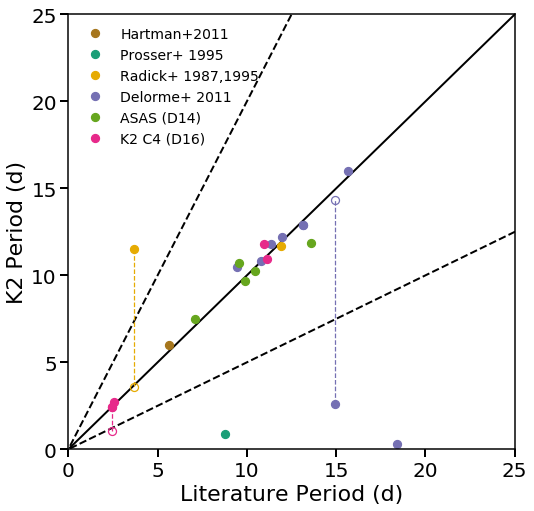

In [93]:

plt.figure(figsize=single_figure)
ax = plt.subplot(111)

x = np.linspace(0.1,99,100)
ax.plot(x,x,'k-',lw=2) 
ax.plot(x,x*2,'k--',lw=2)
ax.plot(x,x/2,'k--',lw=2)

# ax.plot(1/(1.0/x + 1.0),x,'k-.',lw=2)
# ax.plot(x,1/(1.0/x + 1.0/3.0),'k-.')
# for p in np.arange(2,10):
#     ax.plot(1/(1.0/x + 1./p),x,'k-.')
#     ax.plot(x,1/(1.0/x + 1./p),'k-.') # This math might be wrong?
# ax.plot(1/(1/x + 1/29.5),x,'k-.')

diff_set = np.array([])
diff_k2 = np.array([])
diff_lit = np.array([])
for s in ['H','P','R','D','K','2']:
    qual = (pflag==s) & comparison_set
    diff_k2 = np.append(diff_k2,pperiods_onlyk2[qual])
    diff_lit = np.append(diff_lit,pperiods[qual])
    qepic = hdat["EPIC_ID"][qual]
    # Check for significant discrepancies
    diff = abs(pperiods[qual]-pperiods_allk2[qual])/pperiods_allk2[qual]
    sig_diff = np.where(diff>0.1)[0]
    diff_set = np.append(diff_set, np.where(qual)[0][sig_diff])
    # And for secondary periods
    diff_sec = abs(pperiods[qual]-pperiods_secondary[qual])/pperiods_secondary[qual]
    sig_diff_sec = np.where(diff_sec>0.1)[0]
    diff_set = np.append(diff_set, np.where(qual)[0][sig_diff_sec])
    print(s,"With two measurements:",len(np.where(qual)[0]),
          "Significantly different:",len(sig_diff))
    print(qepic[sig_diff])
    print(pperiods[qual][sig_diff])
    print(pperiods_onlyk2[qual][sig_diff])
    if s=="D":
        print(hdat["SWASP_ID"][qual][sig_diff])
#     ax.plot(pperiods[qual],pperiods_allc5[qual],'o',mfc="none",mec=pcolors[s],
#             mew=std_mew,ms=std_ms)
#     ax.plot(pperiods[qual & (pblend==0)],pperiods_allc5[qual & (pblend==0)],'o',
#             mfc=pcolors[s],mec=pcolors[s],label=plabels[s],ms=std_ms,mew=std_mew)
    ax.plot(pperiods[qual],pperiods_allk2[qual],'o',mec=pcolors[s],
            mew=std_mew,ms=std_ms,mfc=pcolors[s],label=plabels[s])
    ax.plot(pperiods[qual & (pperiods_secondary>0)],
            pperiods_secondary[qual& (pperiods_secondary>0)],'o',mec=pcolors[s],
            mew=std_mew,ms=std_ms,mfc="none")
    for i in np.where(qual)[0]:
        if (pperiods_allk2[i]>0) and (pperiods_secondary[i]>0):
            ax.plot([pperiods[i],pperiods[i]],[pperiods_allk2[i],pperiods_secondary[i]],
                   "--",lw=std_mew,color=pcolors[s])
ax.set_xlabel("Literature Period (d)",fontsize=22)
ax.set_ylabel("K2 Period (d)",fontsize=22)
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlim(0,25)
ax.set_ylim(0,25)
ax.tick_params(labelsize=20,width=2, length=8)
ax.tick_params(which="minor",width=2, length=4)
# ax.set_yticklabels(["","0.1","1","10"])
# ax.set_xticklabels(["","0.1","1","10"])
ax.legend(loc=2,frameon=False, numpoints=1)

The Prosser star is EPIC210558541 or VA512. The phase-folded light curve in Prosser is pretty messy. (See the bottom left plot in Fig 1, Page 2) They claim to have observed in in 1992 Nov and 1994 Mar and derived an 8.8 day period with no apparent phase drift, though. There is no evidence for that period in the K2 light curve. The DSS image shows a possible companion (but when I check finder chart it doesn't appear? A stretch issue?)

Delorme mis-matches are 
- EPIC246806983 ([RSP2011] 658; 05 11 09.709	+15 48 57.47) This one shows two periods, though, and the 14ish day period is also detected in the K2 light curve
- EPIC246714118 (LH 75; REID 289; 04 30 33.872	+14 44 53.19). There is some additional modulation in the K2 light curve but it's not terrible periodic. At best, it might be around 20 days (Periodogram says 23), but there's no way to show it's not systematics

I couldn't find light curves for either at https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblSearch/nph-tblSearchInit?app=ExoTbls&config=superwasptimeseries

/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


H With two measurements: 1 Significantly different: 0
[]
[]
[]
P With two measurements: 1 Significantly different: 1
[210558541]
[8.8]
[0.9041]
R With two measurements: 2 Significantly different: 1
[210554781]
[3.66]
[11.5143]
D With two measurements: 9 Significantly different: 2
[246806983 246714118]
[14.94 18.41]
[2.6103 0.3216]
K With two measurements: 5 Significantly different: 2
[210666330 247369717]
[ 9.551653 13.589424]
[10.6945 11.8317]
2 With two measurements: 5 Significantly different: 0
[]
[]
[]


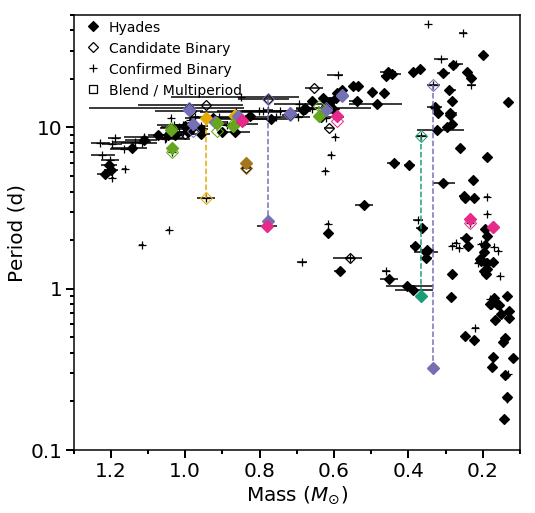

In [85]:
fig = plt.figure(figsize=single_figure)
ax2 = plt.subplot(111)
plot_period_mass(ax=ax2, plot_binaries=True, sources=False, logmass=False, mass_unc=True,
                 which_sources=['H','P','R','D','K','2','3'],qual=0,min_pmem=70,max_bad=0)


diff_set = np.array([])
diff_k2 = np.array([])
diff_lit = np.array([])
for s in ['H','P','R','D','K','2']:
    qual = (pflag==s) & comparison_set
    diff_k2 = np.append(diff_k2,pperiods_onlyk2[qual])
    diff_lit = np.append(diff_lit,pperiods[qual])
    qepic = hdat["EPIC_ID"][qual]
    # Check for significant discrepancies
    diff = abs(pperiods[qual]-pperiods_allk2[qual])/pperiods_allk2[qual]
    sig_diff = np.where(diff>0.1)[0]
    diff_set = np.asarray(np.append(diff_set, np.where(qual)[0][sig_diff]),int)
    # And for secondary periods
    diff_sec = abs(pperiods[qual]-pperiods_secondary[qual])/pperiods_secondary[qual]
    sig_diff_sec = np.where(diff_sec>0.1)[0]
    diff_set_sec = np.asarray(np.append(diff_set, np.where(qual)[0][sig_diff_sec]),int)
    print(s,"With two measurements:",len(np.where(qual)[0]),
          "Significantly different:",len(sig_diff))
    print(qepic[sig_diff])
    print(pperiods[qual][sig_diff])
    print(pperiods_onlyk2[qual][sig_diff])
    
    for i in np.where(qual)[0]:
#         print(i)
        plt.plot([hdat["KH_MASS"][i],hdat["KH_MASS"][i]],[pperiods[i],pperiods_onlyk2[i]],
                 marker="D",color=pcolors[s],ls="--",mfc="none",ms=std_ms)
        plt.plot(hdat["KH_MASS"][i],pperiods_onlyk2[i],
                 "D",color=pcolors[s],ms=std_ms)
#         if (pperiods_secondary[i]>0):
#             plt.plot([hdat["KH_MASS"][i],hdat["KH_MASS"][i]],[pperiods[i],pperiods_secondary[i]],
#                      marker="o",color=pcolors[s],ls="--")
    


In [86]:
diff_frac = abs(diff_k2-diff_lit)/diff_k2
print(min(diff_frac),np.median(diff_frac),np.mean(diff_frac))
print(np.percentile(diff_frac,[20,40,60,80,90]))
print(np.percentile(diff_frac,[25,50,75]))
print(len(diff_frac[diff_frac<0.1]),len(diff_frac),
     len(diff_frac[diff_frac<0.1])/len(diff_frac))

0.0024095991372297234 0.0377843663382016 3.0947428705733744
[0.01820463 0.0222559  0.05816747 0.13188155 3.91521069]
[0.01865649 0.03778437 0.10122587]
17 23 0.7391304347826086


# HIstogram of periodogram powers

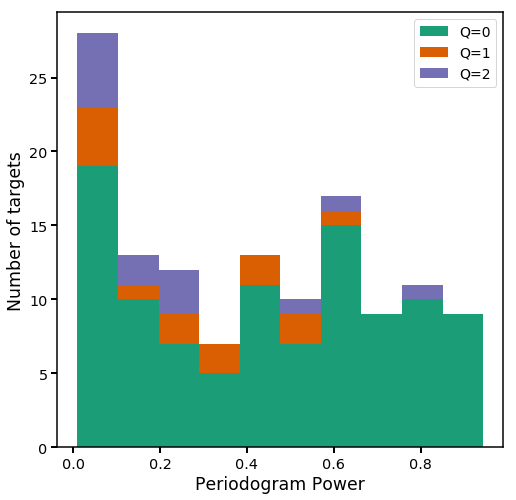

In [36]:
plt.figure(figsize=single_figure)
ax = plt.subplot(111)

good = (pperiods_onlyk2>0)

ax.hist([ppower[good & (pqual==0)], ppower[good & (pqual==1)], ppower[good & (pqual==2)]],
        label=["Q=0","Q=1","Q=2"],histtype="barstacked",color=cmap_qual[:3])

ax.legend(loc=1)
ax.set_xlabel("Periodogram Power",fontsize="xx-large")
ax.set_ylabel("Number of targets",fontsize="xx-large")
ax.tick_params(labelsize="x-large",width=2, length=6)
ax.tick_params(which="minor",width=2, length=3)

[Text(0,0,''), Text(0,0,''), Text(0,0,'0.01'), Text(0,0,'0.1'), Text(0,0,'1')]

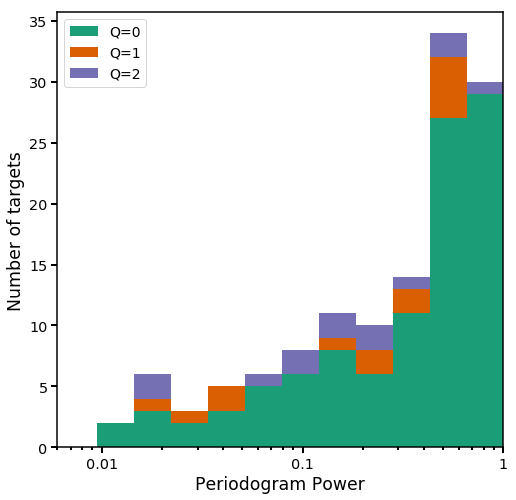

In [37]:
plt.figure(figsize=single_figure)
ax = plt.subplot(111)

good = (pperiods_onlyk2>0)

ax.hist([ppower[good & (pqual==0)], ppower[good & (pqual==1)],
         ppower[good & (pqual==2)]],
        label=["Q=0","Q=1","Q=2"],histtype="barstacked",color=cmap_qual[:3],
        bins=np.logspace(np.log10(min(ppower[ppower>0])),0,12))

ax.set_xlabel("Periodogram Power",fontsize="xx-large")
ax.set_ylabel("Number of targets",fontsize="xx-large")
ax.tick_params(labelsize="x-large",width=2, length=6)
ax.tick_params(which="minor",width=2, length=3)

ax.legend(loc="best")
plt.xscale("log")
plt.xlim(6e-3,1)

ax.set_xticklabels(["","","0.01","0.1","1"],minor=False)

# plt.savefig("/home/stephanie/my_papers/praeK2/powers.pdf",bbox_inches="tight")
# plt.savefig("/home/stephanie/my_papers/praeK2/fig4.pdf",bbox_inches="tight")
# plt.savefig("/home/stephanie/my_papers/praeK2/fig4.eps",bbox_inches="tight")

/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


[Text(0,0,''), Text(0,0,'1'), Text(0,0,'10'), Text(0,0,'100')]

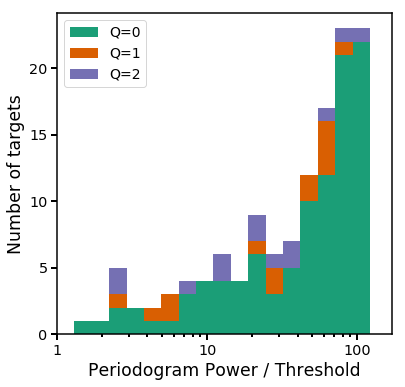

In [38]:
plt.figure(figsize=double_stacked)
ax = plt.subplot(211)

good = (pperiods_onlyk2>0)

ratio = ppower/pthreshold

ax.hist([ratio[good & (pqual==0)], ratio[good & (pqual==1)], ratio[good & (pqual==2)]],
        label=["Q=0","Q=1","Q=2"],histtype="barstacked",color=cmap_qual[:3]
        ,bins=np.logspace(0,2.2,20))

ax.set_xlabel("Periodogram Power / Threshold",fontsize="xx-large")
ax.set_ylabel("Number of targets",fontsize="xx-large")
ax.tick_params(labelsize="x-large",width=2, length=6)
ax.tick_params(which="minor",width=2, length=3)

ax.legend(loc="best")
plt.xscale("log")
plt.xlim(1,170)

ax.set_xticklabels(["","1","10","100"],minor=False)

In [100]:
hdat["PERIOD"][(hdat["PERIOD"]>-99) & (hdat["PERIOD"]<0.01)]

array([], dtype=float32)

In [99]:
hdat["BINARY"][hdat['BINARY']<0]

array([], dtype=float32)